# Génération de données synthétiques anonymisées pour les applications biomédicales

### Introduction

Ce projet a pour objectif de générer des **données synthétiques anonymisées** en s’appuyant sur la méthode présentée dans l’article  
*“Patient-centric synthetic data generation, no reason to risk re-identification in biomedical data analysis”*, publié dans *npj Digital Medicine* en mars 2023 (Guillaudeux et al., 2023).

L’approche décrite vise à produire des données artificielles fidèles aux distributions réelles, tout en garantissant la **non-réidentification des individus**.  
Elle ouvre ainsi des perspectives prometteuses pour :
- l’analyse biomédicale,
- le développement de modèles prédictifs,
- et le **partage sécurisé** de données sensibles dans le **respect de la vie privée**.

Dans ce cadre, nous avons reproduit la méthodologie décrite dans l’article, puis évalué la qualité des données synthétiques générées à l’aide de plusieurs indicateurs : **DCR**, **NNDR** et **matrices de corrélation**.


## Préparation de la Base de Données

### Chargement des données

In [75]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import load_iris
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
warnings.filterwarnings("ignore")
os.environ["LOKY_MAX_CPU_COUNT"] = "4" 
os.environ["OPENBLAS_NUM_THREADS"] = "4"

path = "dataPT2.csv"
pd.set_option('display.max_columns', None)
df = pd.read_csv(path, header=0, sep=";")

### Filtrage des données

Dans cette étape, nous appliquons un **filtrage** pour ne conserver que les **variables quantitatives** de notre jeu de données.  

In [76]:
df['bmi'] = df['bmi'].str.replace(',','.')
df['bmi'] = df['bmi'].str.replace(r'[^\d.]', '', regex=True)
df['bmi'] = pd.to_numeric(df['bmi'], errors='coerce')
df['height'] = df['height'].str.replace(',', '.').astype(float)
df['weight'] = df['weight'].str.replace(',','.')
df['weight'] = df['weight'].str.replace(r'[^\d.]', '', regex=True)
df['weight'] = pd.to_numeric(df['weight'], errors='coerce')
df['d1_sysbp_noninvasive_min'] = df['d1_sysbp_noninvasive_min'].str.replace(',', '.').astype(float)
df['d1_temp_max'] = df['d1_temp_max'].str.replace(',', '.').astype(float)
df['d1_temp_min'] = df['d1_temp_min'].str.replace(',', '.').astype(float)
df['d1_potassium_max'] = df['d1_potassium_max'].str.replace(',', '.').astype(float)
df['d1_potassium_min'] = df['d1_potassium_min'].str.replace(',', '.').astype(float)


variable_quantitative = [
    'h1_sysbp_min',
    'd1_glucose_min',
    'age',
    'd1_glucose_max',
    'd1_potassium_max',
    'd1_potassium_min',
    'd1_spo2_min',
    'd1_heartrate_max',
    'd1_heartrate_min',
    'weight',
    'd1_diasbp_min',
    'd1_mbp_noninvasive_min',
    'd1_mbp_min',
    'd1_sysbp_min',
    'd1_sysbp_noninvasive_min',
    'd1_temp_max',
    'd1_temp_min',
    'h1_diasbp_min',
    'h1_diasbp_noninvasive_min',
    'h1_heartrate_max',
    'h1_heartrate_min',
    'h1_mbp_min',
    'h1_mbp_noninvasive_min',
    'h1_spo2_min',
    'h1_sysbp_max',
    'h1_sysbp_noninvasive_max',
    'h1_sysbp_noninvasive_min',
    'd1_diasbp_noninvasive_min',
    'd1_resprate_max',
    'd1_resprate_min',
    'h1_resprate_max',
    'h1_resprate_min'
]

df =  df[variable_quantitative]

### ⚙️ Prétraitement des données

Avant d’appliquer la PCA ou d’entraîner un modèle, il est essentiel de prétraiter les données :

- Les **valeurs manquantes** dans les variables quantitatives sont imputées à l’aide de la **médiane**, afin de limiter l’impact des valeurs extrêmes.
- Les données sont ensuite **standardisées** (centrées et réduites) à l’aide du `StandardScaler` pour que toutes les variables aient une **moyenne de 0** et un **écart-type de 1**.  
  Cela est indispensable pour que la PCA (qui est sensible à l’échelle des variables) donne des résultats pertinents.


In [77]:
from sklearn.impute import SimpleImputer
imputer_num = SimpleImputer(strategy="median")  #Remplace les NaN par la médiane
df[variable_quantitative] = imputer_num.fit_transform(df[variable_quantitative])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

## 📊 Analyse en Composantes Principales (PCA / ACP)

Nous réalisons dans un premier temps une **Analyse en Composantes Principales (PCA)** sur l’ensemble du jeu de données `df`.  
L’objectif est de visualiser la **variance expliquée** par chaque composante ainsi que la **variance cumulée**, afin de déterminer le **nombre optimal de composantes à conserver**.

Un **seuil de 95 %** de variance expliquée est fixé comme critère de sélection.  
Ce seuil permet de :
- **Réduire la complexité** des données (moins de dimensions),
- **Préserver l’essentiel de l’information statistique utile** pour l’algorithme de génération,
- Éviter de conserver des composantes trop faiblement informatives.

Le but est donc de **trouver un équilibre** entre simplification et fidélité des données.


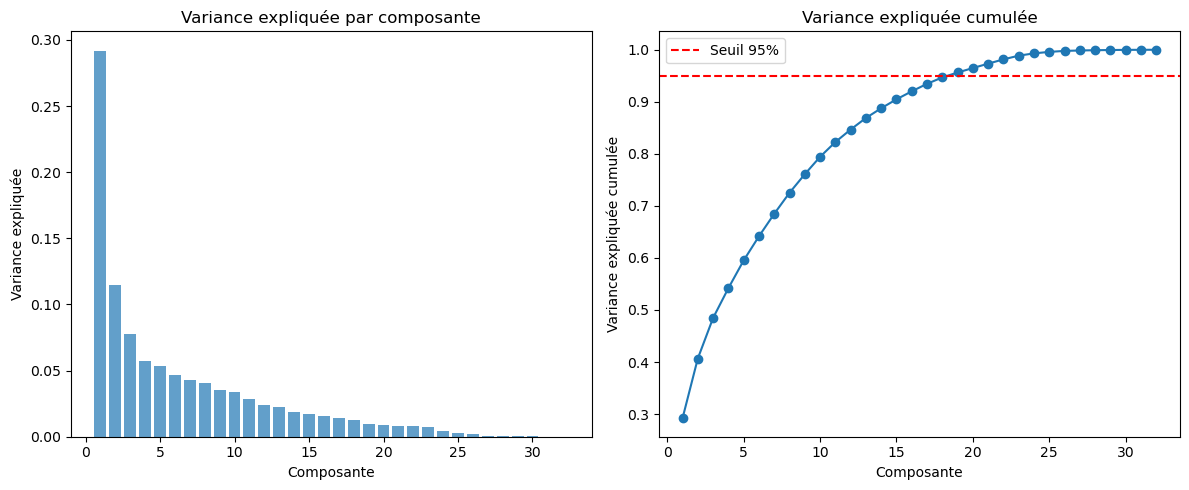

In [78]:
# PCA complète sur toutes les composantes
pca_full = PCA()
pca_full.fit(X_scaled)

# Calcul des variances expliquées et cumulées
explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Visualisation de la variance expliquée par composante et cumulée
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7)
plt.xlabel("Composante")
plt.ylabel("Variance expliquée")
plt.title("Variance expliquée par composante")

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel("Composante")
plt.ylabel("Variance expliquée cumulée")
plt.title("Variance expliquée cumulée")
plt.axhline(y=0.95, color='r', linestyle='--', label='Seuil 95%')
plt.legend()
plt.tight_layout()
plt.show()

### 📉 PCA avec réduction du nombre de composantes

Après avoir observé les courbes d'inertie (variance expliquée), nous choisissons de conserver **17 composantes principales**.  
Ce choix permet de **réduire le nombre de dimensions de 15**, tout en **ne perdant qu’environ 5 % de l'information totale**.  
Cela représente un bon compromis entre **réduction de la complexité** et **conservation de la structure des données**.


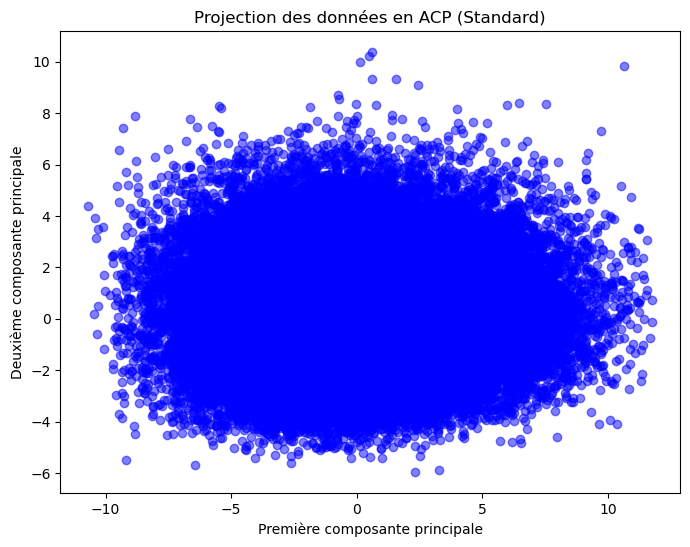

In [79]:
# Choix du nombre de composants
n_components = 17

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='blue', alpha=0.5)
plt.xlabel('Première composante principale')
plt.ylabel('Deuxième composante principale')
plt.title("Projection des données en ACP (Standard)")
plt.show()


## 🛠️ Fonction de génération de données synthétiques

Cette fonction permet de :

- Appliquer une **réduction de dimension** via l'Analyse en Composantes Principales (PCA),
- Réduire le nombre de composantes selon un paramètre défini (`n_components`),
- Puis appliquer la **formule de pondération** issue de l’article de Guillaudeux et al. (2023) pour générer un point synthétique à partir des k plus proches voisins.

### Formule utilisée :

Pour chaque i dans \\([1, \dots, k]\\), on calcule :

$$
P_i = D_i \cdot R_i \cdot C_i
$$

où :

- **D_i** : l’inverse de la distance entre le point d’origine \\(O\\) et son iᵉ voisin parmi les k plus proches,
- **R_i** ~ ξ(1) : un poids aléatoire suivant une loi **exponentielle** de paramètre λ = 1,
- **C_i** = \\( \left(\frac{1}{2}\right)^j \\) : une contribution pondérée, où **j** est la position de l’indice i dans une permutation aléatoire de \\([1, 2, ..., k]\\).

Enfin, on normalise les poids :

$$
W_i = \frac{P_i}{\sum_{j=1}^k P_j}
$$

Ces poids normalisés servent à reconstruire un point synthétique comme une combinaison linéaire pondérée des voisins sélectionnés dans l’espace réduit par PCA.

In [80]:
def pca_with_custom_adjustment(df, n_components=17, k=15, random_state=None):
    """
    Paramètres
    ----------
    df : pd.DataFrame
    n_components : int
        Nombre de composantes principales à conserver.
    k : int
        Nombre de plus proches voisins à considérer pour chaque point.
    random_state : int
        Graine pour la reproductibilité.
    --------
    df_reconstructed : pd.DataFrame
        Données reconstruites après ACP et ajustement.
    """
    if random_state is not None:
        np.random.seed(random_state)

    # Standardisation
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df)
    
    # Réduction de dimension
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)

     # Recherche des k+1 plus proches voisins
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(X_pca)
    distances, indices = nbrs.kneighbors(X_pca)

    # Calcul des vecteurs de pondération globaux
    vec = np.arange(1, k+1)
    np.random.shuffle(vec)

 # Initialisation de la matrice modifiée
    X_pca_modified = np.zeros_like(X_pca)
    n_samples = X_pca.shape[0]
    
    # Pour chaque point, calculer la pondération basée sur ses voisins locaux
    for j in range(n_samples):
        # Exclure le point lui-même (première colonne)
        distances_j = distances[j, 1:]
        
        # Calcul de D_j : l'inverse des distances (avec epsilon pour éviter la division par zéro)
        D_j = 1.0 / (distances_j + 1e-10)
        
        # Générer des poids locaux pour le point j :
        # R_local : tiré d'une loi exponentielle
        R_local = np.random.exponential(scale=1.0, size=k)
        # C_local : généré à partir d'un vecteur aléatoire basé sur 1/(2^indice)
        vec_local = np.arange(1, k+1)
        np.random.shuffle(vec_local)
        C_local = 1 / (2 ** vec_local)
        
        # Calcul du poids local pour le point j
        P_local = D_j * R_local * C_local
        neighbors_pca = X_pca[indices[j, 1:], :] # les k voisins
        W_normalized = P_local / np.sum(P_local) # normalisation
        # La normalisation permet d'éviter l'effet des k voisins qui vont avoir tendance à centrer les données vers le centre
        
        # Combinaison pondérée des voisins
        X_pca_modified[j, :] = np.dot(W_normalized, neighbors_pca)
    
    # Reconstruction inverse
    X_reconstructed_scaled = pca.inverse_transform(X_pca_modified)
    # Retour à l'échelle d'origine
    X_reconstructed = scaler.inverse_transform(X_reconstructed_scaled)
    df_reconstructed = pd.DataFrame(X_reconstructed, columns=df.columns)
    
    return df_reconstructed

## 🔄 Application de la méthode de génération

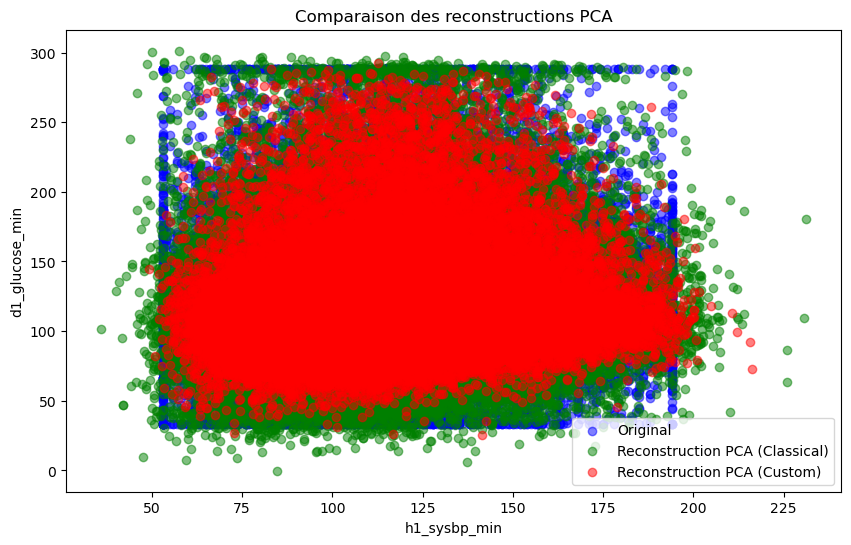

In [81]:
df_reconstructed = pca_with_custom_adjustment(df, n_components=n_components, k=25, random_state=42)

# Reconstruction classique par PCA
# Restandardisation et PCA avec n_components, puis reconstruction inverse
scaler_classical = StandardScaler()
X_scaled_classical = scaler_classical.fit_transform(df)

pca_classical = PCA(n_components=n_components)
X_pca_classical = pca_classical.fit_transform(X_scaled_classical)

X_reconstructed_scaled_classical = pca_classical.inverse_transform(X_pca_classical)
df_classical_reconstructed = pd.DataFrame(
    scaler_classical.inverse_transform(X_reconstructed_scaled_classical),
    columns=df.columns
)

plt.figure(figsize=(10, 6))
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], color='blue', alpha=0.5, label='Original')
plt.scatter(df_classical_reconstructed.iloc[:, 0], df_classical_reconstructed.iloc[:, 1],
            color='green', alpha=0.5, label='Reconstruction PCA (Classical)')
plt.scatter(df_reconstructed.iloc[:, 0], df_reconstructed.iloc[:, 1],
            color='red', alpha=0.5, label='Reconstruction PCA (Custom)')
plt.xlabel(df.columns[0])
plt.ylabel(df.columns[1])
plt.title("Comparaison des reconstructions PCA")
plt.legend()
plt.show()

On remarque sur le graphique, en bleu les données orginales, en vert les données avec recomposition de la PCA uniquement. On remarque que les données reconstruites correspondent bien aux données originales.
Avec l'utilisation du k plus proche voisin, on pourrait s'attendre à ce que les données en rouge, qui sont les données reconstruites et anonymisées, soient plus centrée vers le centre des données. En effet, l'utilisation des k plus proche voisin qui vont avoir tendance à réduire les extrèmes et rapprocher les données vers le centre. Ceci est résolu par Wi qui normalise et permet de garder la structure locale sans recopier un point voisin réel.

# Métriques

On choisit de prendre un échantillon pour le calcul des métriques car le coût computationnel est très élevé sur des grandes bases de données.

### 🧮 Fonction de calcul du DCR et du NNDR pour les données réelles

In [82]:
def calculate_dcr_nndr_self(df, sample_size=5000, random_state=None):
    # Conversion en array
    X = df.values

    # Échantillonnage
    n_total = X.shape[0]
    if n_total > sample_size:
        np.random.seed(random_state)
        idx = np.random.choice(n_total, size=sample_size, replace=False)
        X_sample = X[idx]
    else:
        X_sample = X

    # Initialiser NearestNeighbors pour 2 voisins
    nn = NearestNeighbors(n_neighbors=2, metric='euclidean')
    nn.fit(X_sample)

    # Trouver les deux plus proches voisins pour chaque point (le 1er est lui-même)
    distances, indices = nn.kneighbors(X_sample)

    # On prend la distance au 2e voisin (le 1er est soi-même donc distance = 0)
    dcr_values = distances[:, 1]

    # NNDR = distance au 2e / distance au 3e (il faut 3 voisins au lieu de 2 pour ça)
    nn_nndr = NearestNeighbors(n_neighbors=3, metric='euclidean')
    nn_nndr.fit(X_sample)
    distances_nndr, _ = nn_nndr.kneighbors(X_sample)
    
    epsilon = 1e-9
    nndr_values = distances_nndr[:, 1] / (distances_nndr[:, 2] + epsilon)

    dcr_mean = np.mean(dcr_values)
    nndr_mean = np.mean(nndr_values)

    print(f"DCR réel : {dcr_mean:.3f}")
    print(f"NNDR réel : {nndr_mean:.3f}")

    return dcr_mean, nndr_mean

### 🧮 Fonction de calcul du DCR et du NNDR pour les données synthétiques

In [83]:
def calculate_dcr_nndr(df, df_reconstructed, sample_size=5000, random_state=None):
    # Conversion en arrays
    X_real = df.values
    X_synth = df_reconstructed.values

    # Échantillonnage pour alléger le calcul
    n_total = X_real.shape[0]
    if n_total > sample_size:
        np.random.seed(random_state)
        idx = np.random.choice(n_total, size=sample_size, replace=False)
        X_real_sample = X_real[idx]
        X_synth_sample = X_synth[idx]
    else:
        X_real_sample = X_real
        X_synth_sample = X_synth

    # Initialiser NearestNeighbors pour trouver les 2 plus proches voisins dans les données réelles
    nn = NearestNeighbors(n_neighbors=2, metric='euclidean')
    nn.fit(X_real_sample)

    # Pour chaque enregistrement synthétique, trouver les distances aux deux voisins réels les plus proches
    distances, indices = nn.kneighbors(X_synth_sample)
    
    # DCR : distance au premier voisin (le plus proche)
    dcr_values = distances[:, 0]
    dcr_mean = np.mean(dcr_values)
    
    # NNDR : ratio entre la distance au premier voisin et celle au deuxième voisin
    # On ajoute un petit epsilon pour éviter la division par zéro.
    epsilon = 1e-9
    nndr_values = distances[:, 0] / (distances[:, 1] + epsilon)
    nndr_mean = np.mean(nndr_values)
    
    print(f"DCR généré : {dcr_mean:.3f}")
    print(f"NNDR généré: {nndr_mean:.3f}")
    
    return dcr_mean, nndr_mean

## DCR (Distance to Closest Record)

### 📏 Interprétation de la métrique DCR

Le **DCR** (*Distance au plus proche voisin*) correspond à la **distance euclidienne** entre chaque enregistrement synthétique et son plus proche voisin dans le jeu de données réelles.

- Un **DCR trop proche de 0** indique que le point généré est **très proche d’un enregistrement réel**, ce qui pourrait poser un **risque de ré-identification**.

- Au contraire, un **DCR trop élevé** signifie que la **structure de proximité a été fortement altérée**, ce qui pourrait **réduire l’utilité statistique** des données synthétiques.


In [84]:
dcr, nndr = calculate_dcr_nndr_self(df, sample_size=5000, random_state=42)
dcr, nndr = calculate_dcr_nndr(df, df_reconstructed, sample_size=5000, random_state=42)

DCR réel : 49.791
NNDR réel : 0.918
DCR généré : 37.072
NNDR généré: 0.893


## NNDR (Nearest Neighbor Distance Ratio)

### 🔍 Interprétation de la métrique NNDR

Le **NNDR** (*Nearest Neighbor Distance Ratio*) est le **ratio entre la distance au premier voisin (le plus proche)** et celle au **deuxième voisin**, calculé pour chaque enregistrement synthétique par rapport aux données réelles.

- Si le **NNDR est proche de 1**, cela signifie que les **deux voisins sont à des distances similaires**, indiquant qu’il n’y a **pas de voisin particulièrement dominant**. C’est un bon indicateur de confidentialité.

- Si le **NNDR est très faible**, cela signifie que le **premier voisin est beaucoup plus proche que le second**, ce qui peut indiquer que le **point généré est fortement "lié" à un enregistrement réel**, augmentant ainsi le **risque de ré-identification**.


In [85]:
dcr, nndr = calculate_dcr_nndr_self(df, sample_size=5000, random_state=42)
dcr, nndr = calculate_dcr_nndr(df, df_reconstructed, sample_size=5000, random_state=42)

DCR réel : 49.791
NNDR réel : 0.918
DCR généré : 37.072
NNDR généré: 0.893


## 📏 Analyse et interprétation des métriques DCR et NNDR

Les données synthétiques diffusées sont générées artificiellement à partir de **structures locales** des données réelles, avec une **injection de bruit contrôlée**.  
Les distances entre données synthétiques et données réelles ont été mesurées à l’aide des métriques **DCR (Distance au plus proche voisin)** et **NNDR (Ratio entre les deux plus proches voisins)**.  
Ces métriques permettent de mesurer le compromis entre **réalisme statistique** et **protection de la vie privée**.

Elles sont essentielles pour évaluer l’équilibre entre :
- **Utilité** : capacité des données synthétiques à représenter fidèlement les structures locales des données originales.
- **Confidentialité** : capacité à éviter toute ré-identification d’un individu réel.

---

### Résultats obtenus

- **DCR synthétique < DCR réelle**  
  Cela signifie que certaines données synthétiques sont plus proches d’un individu réel que deux individus réels entre eux.  
  Ce **léger risque de réidentification** peut être atténué en **augmentant le paramètre *k*** ou en **modifiant certains coefficients de pondération** dans la formule de génération.

- **NNDR synthétique ≈ NNDR réelle**  
  Le ratio entre les deux plus proches voisins reste proche de celui des vraies données, ce qui est un **bon indicateur** :  
  cela signifie qu’aucune donnée synthétique ne forme de pair "évidente" ou trop unique, ce qui **limite les risques de ré-identification directe**.

---

### Conclusion

Les métriques obtenues suggèrent que la méthode employée produit des données synthétiques **globalement réalistes**, tout en maintenant un niveau **raisonnable de confidentialité**.  
De légers ajustements peuvent encore être envisagés pour renforcer la protection, sans trop altérer la structure statistique des données.

## Matrice de corrélation

### Corrélations des données réelles :

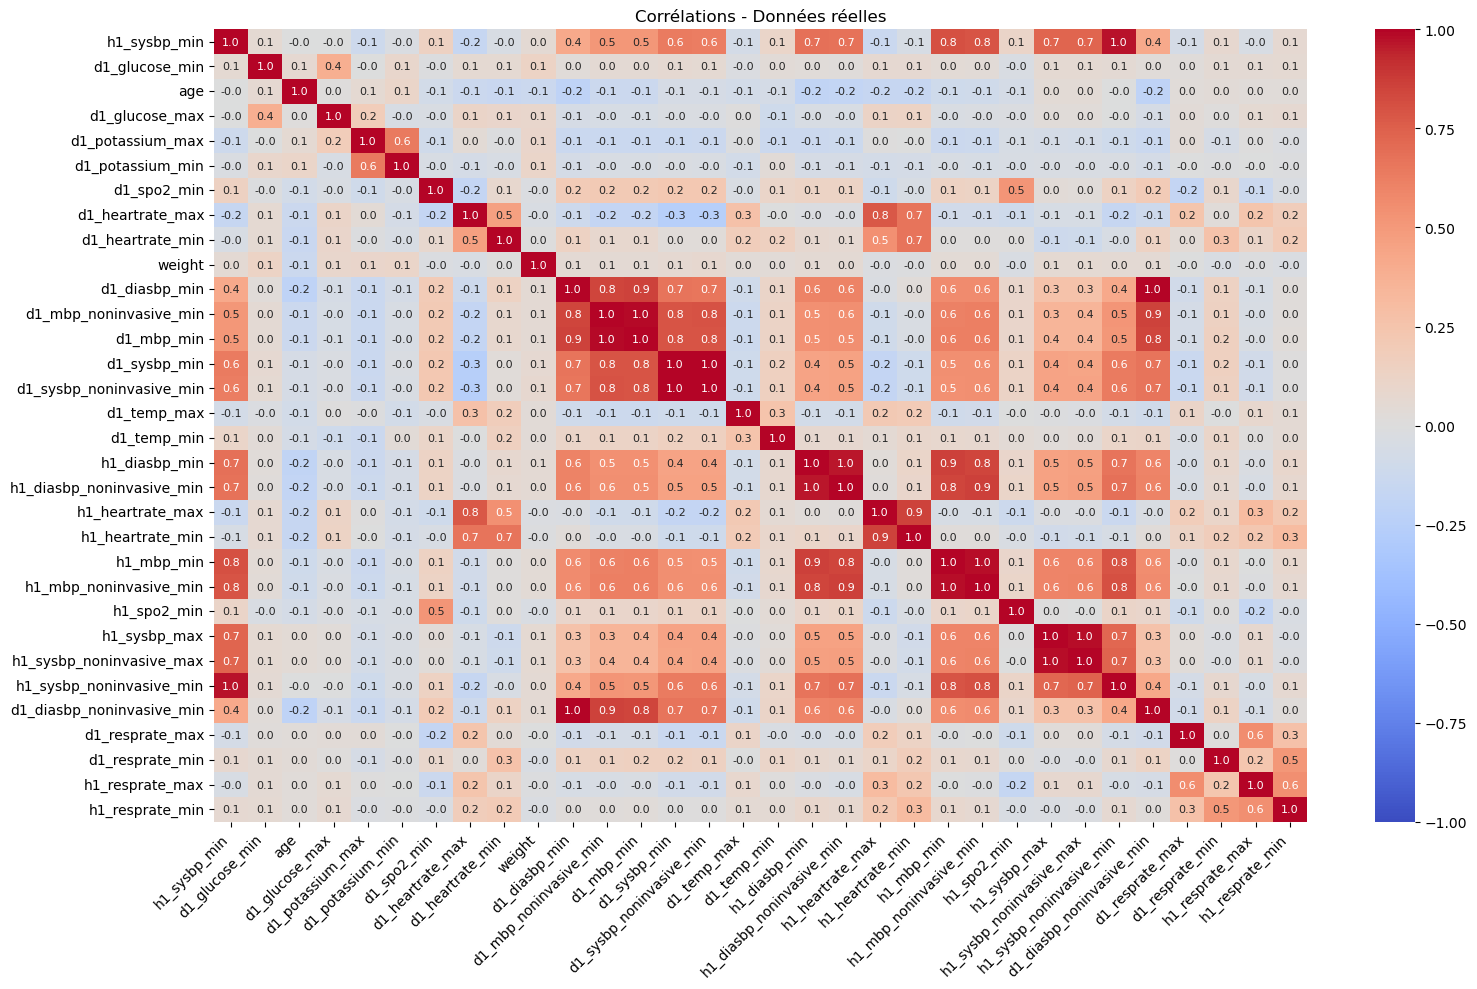

In [86]:
def plot_corr_real(df):
    corr_real = df.corr()

    plt.figure(figsize=(16, 10))
    sns.heatmap(corr_real, cmap="coolwarm", vmin=-1, vmax=1, annot=True, fmt=".1f", annot_kws={"size": 8})
    plt.title("Corrélations - Données réelles")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return corr_real

corr_real = plot_corr_real(df)

### Corrélations des données synthétiques

In [87]:
def plot_corr_synth(df_reconstructed):
    corr_synth = df_reconstructed.corr()

    plt.figure(figsize=(16, 10))
    sns.heatmap(corr_synth, cmap="coolwarm", vmin=-1, vmax=1, annot=True, fmt=".1f", annot_kws={"size": 8})
    plt.title("Corrélations - Données synthétiques")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return corr_synth

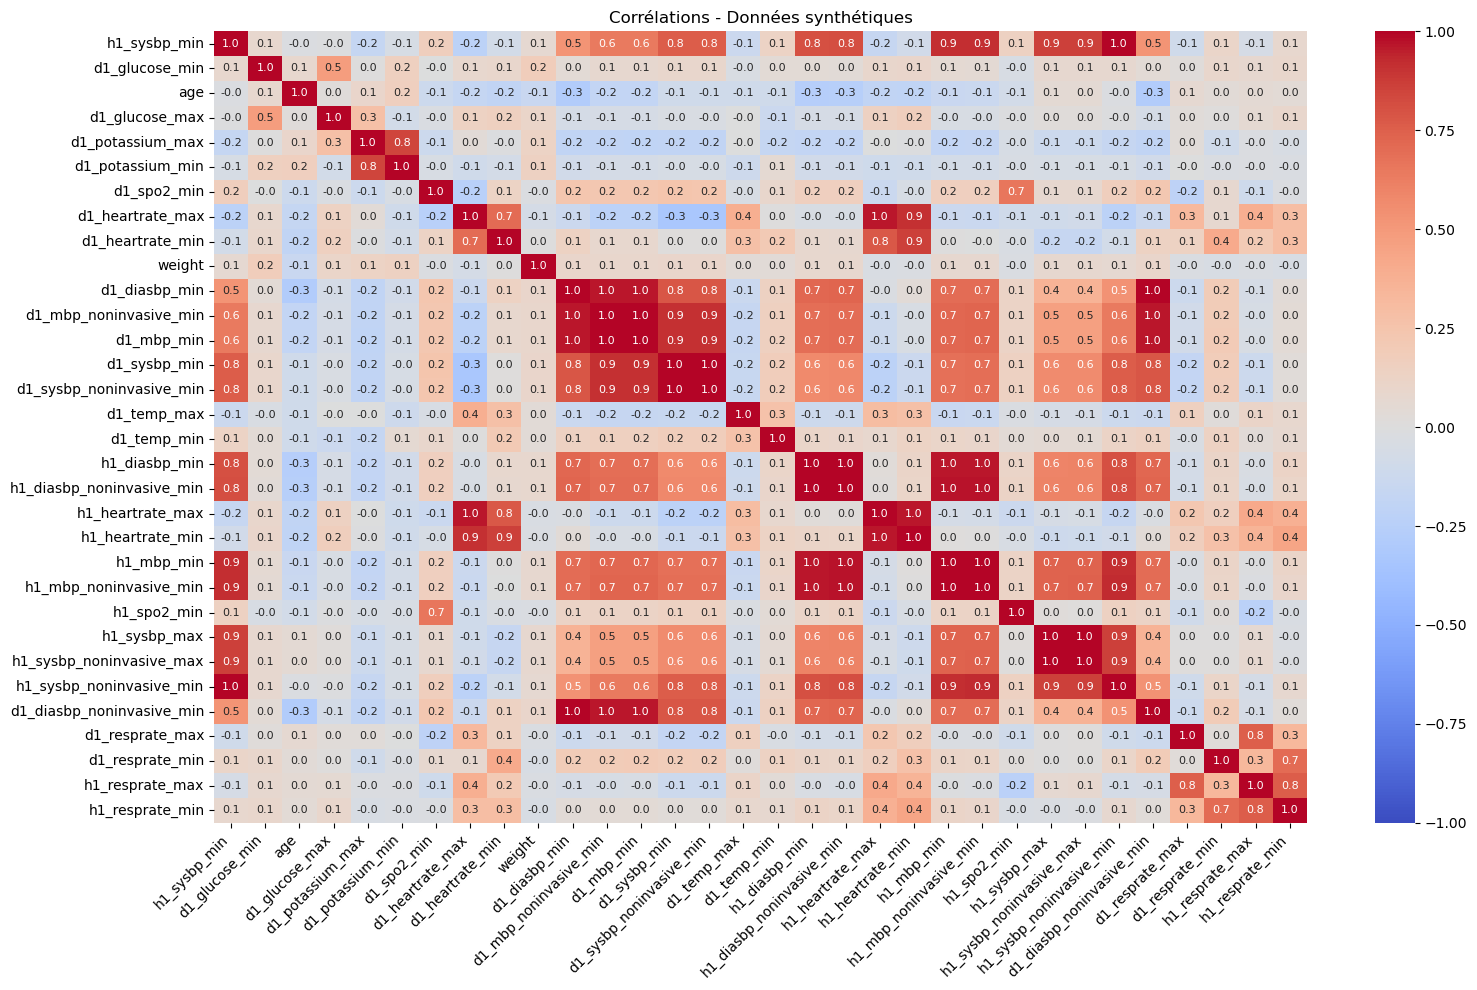

In [88]:
corr_synth = plot_corr_synth(df_reconstructed)

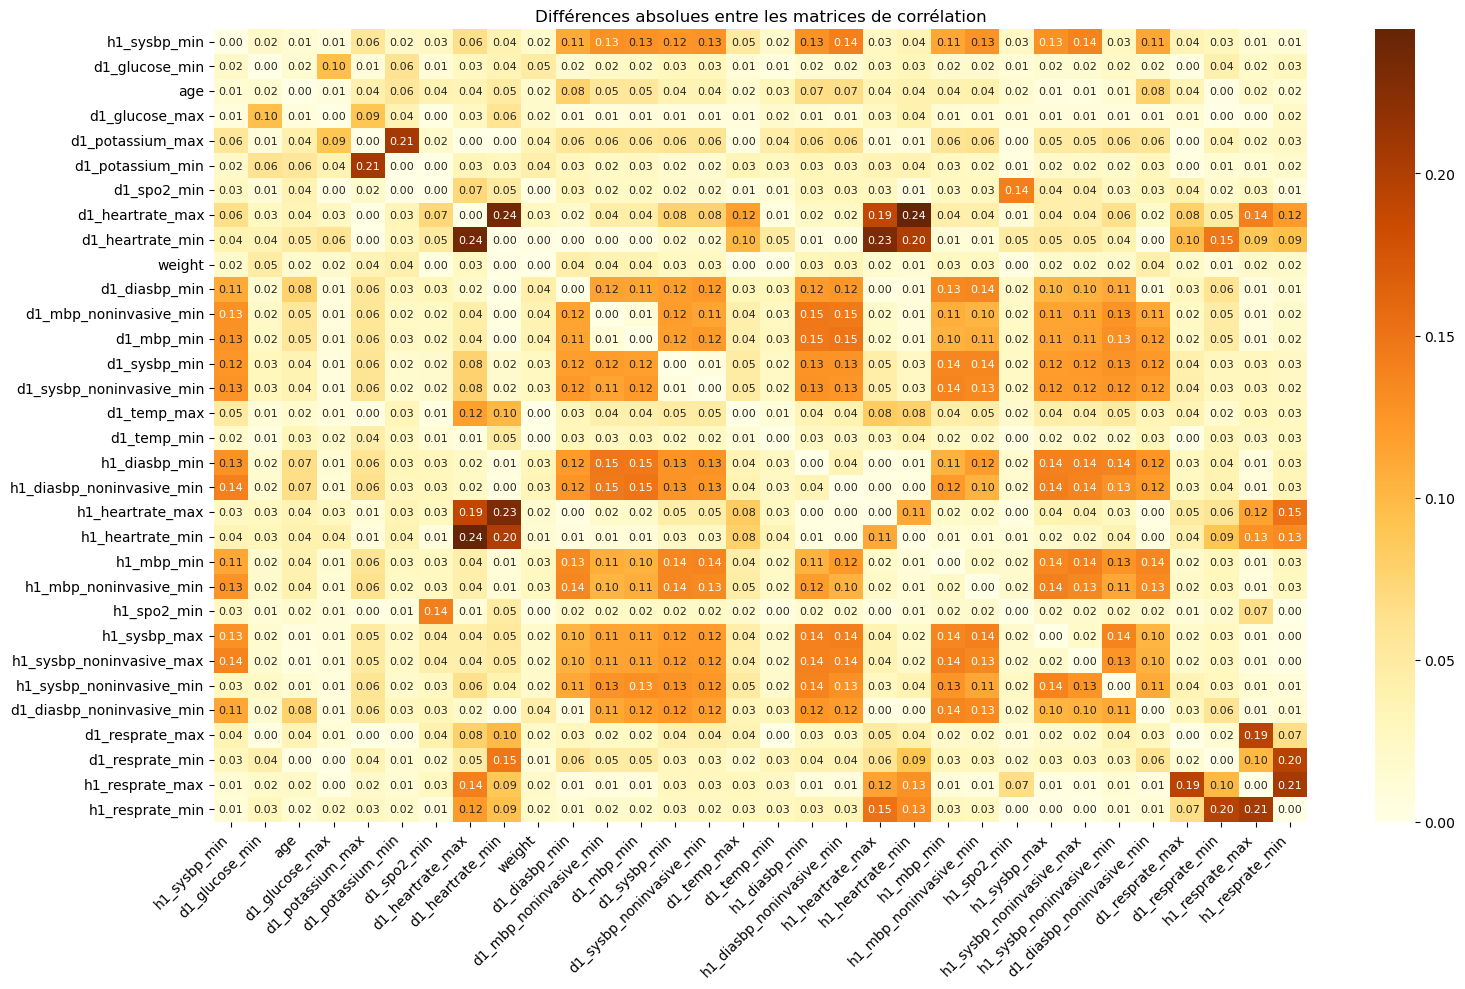

In [89]:
def plot_corr_diff(corr_real, corr_synth):
    # Calcul de la matrice des différences absolues
    diff_matrix = np.abs(corr_real - corr_synth)

    # Affichage
    plt.figure(figsize=(16, 10))
    sns.heatmap(diff_matrix, cmap="YlOrBr", annot=True, fmt=".2f", annot_kws={"size": 8})
    plt.title("Différences absolues entre les matrices de corrélation")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return diff_matrix

diff_matrix = plot_corr_diff(corr_real, corr_synth)

In [90]:
diff_matrix = np.abs(corr_real - corr_synth)
mean_diff = np.mean(diff_matrix.values)
print(f"Écart moyen entre les matrices de corrélation : {mean_diff:.4f}")

Écart moyen entre les matrices de corrélation : 0.0481


### 📐 Interprétation de l'écart entre les matrices de corrélation

On vérifie l’**écart moyen entre les deux matrices de corrélation**.  
S’il est **proche de 0** (par exemple, inférieur à **0.05**, comme c’est le cas ici), cela signifie que la **structure des corrélations est bien conservée** dans les données synthétiques.

En revanche, si l’écart est **élevé** (par exemple, supérieur à **0.2**), cela indique une **altération des relations entre les variables**, rendant les données synthétiques **moins exploitables analytiquement**.

La matrice représentant les **différences absolues** entre les deux matrices de corrélation révèle que les variables dans les données synthétiques sont **plus fortement corrélées entre elles**, tout en **conservant la même structure globale de corrélation** que les données réelles.


# Conclusion

Dans le cadre de ce projet, nous avons mis en œuvre une méthode de génération de données synthétiques anonymisées, en nous inspirant des principes décrits par *Guillaudeux et al.* (2023). L’objectif était de produire des données simulées réalistes tout en garantissant la protection de la vie privée des individus d'origine.

Pour évaluer la qualité des données générées, plusieurs indicateurs ont été utilisés :

- **DCR (Distance au plus proche voisin)** : permet de mesurer la proximité entre une donnée synthétique et sa correspondante réelle la plus proche. Une DCR modérée indique une bonne anonymisation.
- **NNDR (Nearest Neighbor Distance Ratio)** : évalue le caractère unique ou isolé d’un point synthétique. Des valeurs dans la plage attendue montrent qu’aucune donnée n’est trop proche d’un point réel unique.
- **Matrices de corrélation** : utilisées pour vérifier la préservation des relations statistiques entre les variables. Une bonne concordance entre matrices réelle et synthétique garantit une structure cohérente.

Les résultats obtenus suggèrent que le modèle de génération utilisé offre un bon compromis entre **confidentialité** et **faisabilité analytique**. Les distances DCR sont raisonnables, les ratios NNDR dans la norme, et les structures de corrélation fidèlement reproduites.

Ce travail ouvre la voie à une utilisation plus large des **données synthétiques** dans le domaine biomédical, en favorisant un **partage sécurisé des données** sans compromettre la **vie privée des patients**.